TASK : Load the dataset and plot the original data and moving average of the order you think is
the most appropriate and explain why.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("data.csv")
data['ev_date'] = pd.to_datetime(data['ev_date'], format='%Y%m%d')
data = data.set_index('ev_date')


In [ ]:
data = data.asfreq(freq='D')
data['MA3'] = data['avg_events_per_user'].rolling(window=3, center=True,min_periods=1).mean()
data['MA7'] = data['avg_events_per_user'].rolling(window=7, center=True,min_periods=1).mean()
data['MA15'] = data['avg_events_per_user'].rolling(window=15, center=True,min_periods=1).mean()


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(data.index, data['avg_events_per_user'], marker='o', linestyle='-', label='Original Data')
plt.plot(data.index, data['MA7'], marker='o', linestyle='dashed', label='3-Day MA')
plt.title('Average Daily Events Per User Over Time vs 3 Day Moving Average')  
plt.xlabel('Event Date')
plt.ylabel('Average Events Per User')  
plt.grid(True) 
plt.tight_layout()  
plt.show()


Answer: I would suggest using 7 day moving average window, as it provides a useful data useful for determining trend of the data. I woudn't use 15 day moving average window, as dataset is relatively short and fluctuates a lot, therefore using bigger data span doesnt provide any more insightful graficon. With 7 day rolling window we got sense of the trend in data.

In [ ]:
data = data.drop(columns=['MA3','MA15'])

TASK: 
- Decompose the time series using STL and Classical decomposition, write one or two sentences explaining what you see from data obtained by decomposition. 
- What differences do you see between the trend charts for two methods ?
-  Which method do you think works best for understanding our data and why ?

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
#classical decomposition - additive
seasonal_decomp = seasonal_decompose(data['avg_events_per_user'], model="additive")
fig=seasonal_decomp.plot()
fig.set_size_inches(10, 8) 
plt.show()

In [ ]:
#classical decomposition - multiplicative
seasonal_decomp = seasonal_decompose(data['avg_events_per_user'], model="multiplicative")
fig=seasonal_decomp.plot()
fig.set_size_inches(10, 8) 
plt.show()

Answer: For the classical seasonal decomposition using additive and multiplicative methods, we can see the following:
- seasonal component is very pronouncd and regular, repeting constanly over time, indicating strong weekly seasonality that is continuous over time
- residuals are looking less predictable when using additive model, rather than multiplicative, but random in both cases
- there is no strong trend present in the data

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
stl_decomp = STL(data['avg_events_per_user'], seasonal=7)
res = stl_decomp.fit()
fig = res.plot()
fig.set_size_inches(10,8) 
plt.show()

Answer : Visually, classical decomposition has had "better" visual results, looking at the residuals; since the residuals in the case of STL decomposition, no matter the seasonal period to look at, are still scattered what could be observed as random, and given that season in STL decomposition is imperfect compared to seasonality in classical decomposition (with either method), I would suggest that classical decomposition would be more appropriate choice.
Trend line is smoother in case of STL decomposition, which makes perfect sense, knowing that the STL decomposition uses LOESS, which smoothes the curve. In this case though, residuals have not adequately minimized.

TASK: Check if data is stationary, explain what you are doing as you write code checking stationarity of the data.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

Performing Unit Root Test

1. performing Unit test. 
- H0 - data is stationary

In [ ]:
sm.tsa.stattools.kpss(data['avg_events_per_user'], regression='ct')

Conclusion: since the KPSS statistic is 0.1631 and the critical value at significance level of 0.05% is 0.146, it is clear that the statistic is greater than the critical value, therefore we can reject the null hypothesis that the data is stationary.

Performing Augmented Dickey-Fuller (ADF) to determine data stationarity.
- H0: There is a unit roor, and data is non stationary.
- H1: There is no unit root and the data is stationary.

In [ ]:
test_statistic = adfuller(data['avg_events_per_user'])
print('ADF Statistic: %f' % test_statistic[0])
print('p-value: %f' % test_statistic[1])
print('Critical Values:')
for key, value in test_statistic[4].items():
    print('\t%s: %.3f' % (key, value))

At the significance level of alfa=0.05, we cannot reject the null hypothesis, as the p-value is higher than the alfa. Therefore, data is not stationary. This aligns with the previous test.

Data will be differenced and another adfulller test will be conducted to see if first order differenced data is stationary or not.

In [ ]:
data['FO_diff'] = data['avg_events_per_user'].diff()
data['FO_diff'].fillna(method='bfill', inplace=True)  
data.head()

In [ ]:
test_statistic = adfuller(data['FO_diff'])
print('ADF Statistic: %f' % test_statistic[0])
print('p-value: %f' % test_statistic[1])
print('Critical Values:')
for key, value in test_statistic[4].items():
    print('\t%s: %.3f' % (key, value))

Conclusion: first order differenced data is stationary.

Plotting ACF and PACF over original and first order differenced data 

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_acf(data['avg_events_per_user'], lags=20, ax=axes[0, 0])
axes[0, 0].set_title('ACF of Original Data')

plot_acf(data['FO_diff'], lags=20, ax=axes[1, 0])
axes[0, 1].set_title('ACF of First-Order Differenced Data')

plot_pacf(data['avg_events_per_user'], lags=20, ax=axes[0, 1])
axes[1, 0].set_title('PACF of Original Data')

plot_pacf(data['FO_diff'], lags=20, ax=axes[1, 1])
axes[1, 1].set_title('PACF of First-Order Differenced Data')

plt.tight_layout()
plt.show()


TASK:
- Use period 2023-01-01 => 2023-05-15 as your train dataset and 2023-05-16 =>
2023-05-30 as test dataset
- Using methods: ARIMA, Exponential Smoothing
- Make in-sample predictions and plot them
- Make 15 day predictions and plot them
- Make 15 day predictions using Naive, Seasonal Naive and Mean method, plot them
along with your model (❗for seasonal naive method: as you don’t have last year
data, use same 15 day period from previous month), calculate the MAE and RMSE
for all methods and compare them


In [116]:
train_data = data[data.index <= pd.to_datetime('20230515',format='%Y%m%d')]
test_data = data[data.index > pd.to_datetime('20230515',format='%Y%m%d')]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA as ARIMA

Grid search over parameter space. finding the best ARIMA model 

In [ ]:
p,q = range(0,21),range(0,21)

In [ ]:
best_aic = float('inf')
best_order = None
best_model = None

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)

for p_val in p:
    for q_val in q:
        try:
            model = sm.tsa.ARIMA(train_data['avg_events_per_user'], order=(p_val, 1, q_val))  
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p_val, 1, q_val)
                best_model = results
        except Exception as e:
            print(f"Failed to fit ARIMA({p_val},1,{q_val}): {str(e)}")
            continue

In [ ]:
print('Best ARIMA {} AIC:{}'.format(best_order, best_aic))

Using ARIMA (6,1,7) to make predictions on test dataset.

In [117]:
model = sm.tsa.ARIMA(train_data['avg_events_per_user'], order=(6,1,7))
fitted_model = model.fit() 

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [118]:
forecast = fitted_model.get_forecast(steps=len(test_data))
mean_forecast = forecast.predicted_mean

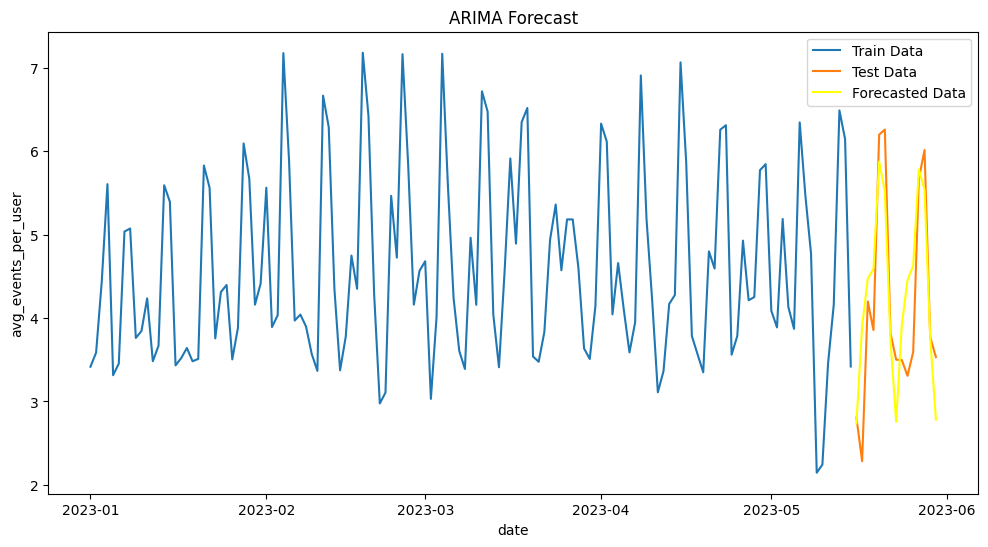

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['avg_events_per_user'], label='Train Data')
plt.plot(test_data.index, test_data['avg_events_per_user'], label='Test Data')
plt.plot(test_data.index, mean_forecast, label='Forecasted Data', color='yellow', )
plt.title('ARIMA Forecast')
plt.xlabel('date')
plt.ylabel('avg_events_per_user')
plt.legend()
plt.show()

In [120]:
test_data['arima_preds'] = mean_forecast

C:\Temp\ipykernel_27520\3212825175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['arima_preds'] = mean_forecast


Exponential smoothing model 

In [121]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.statespace import exponential_smoothing

In [122]:
ES = exponential_smoothing.ExponentialSmoothing
config = {"trend": True}   
stlf = STLForecast(train_data['avg_events_per_user'], ES, model_kwargs=config)
res = stlf.fit()
es_forecasts = res.forecast(len(test_data))

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


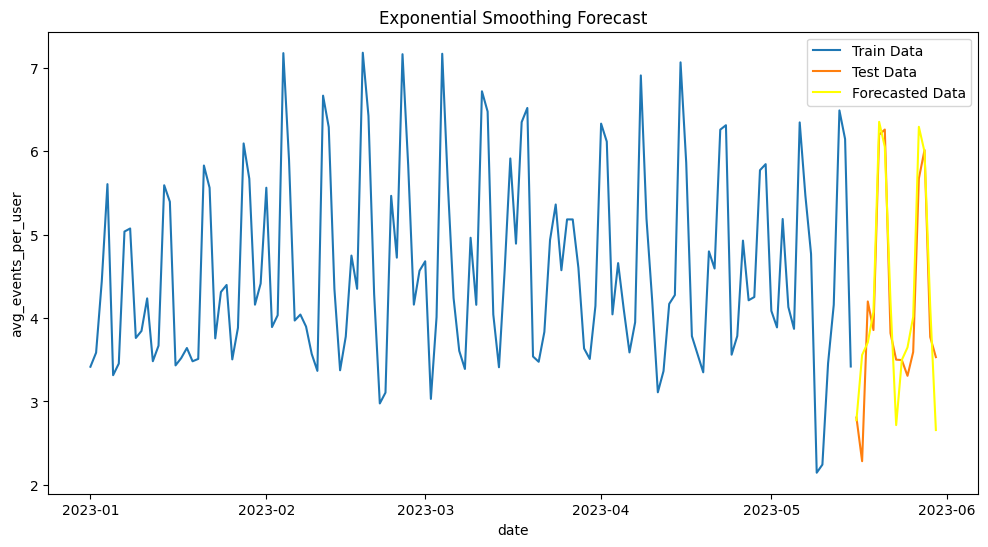

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['avg_events_per_user'], label='Train Data')
plt.plot(test_data.index, test_data['avg_events_per_user'], label='Test Data')
plt.plot(test_data.index, es_forecasts, label='Forecasted Data', color='yellow', )
plt.title('Exponential Smoothing Forecast')
plt.xlabel('date')
plt.ylabel('avg_events_per_user')
plt.legend()
plt.show()

In [124]:
test_data['es_preds'] = es_forecasts

C:\Temp\ipykernel_27520\4242870156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['es_preds'] = es_forecasts


Naive method 

In [125]:
last_value = train_data['avg_events_per_user'].iloc[-1]

naive_forecasts = [last_value for _ in range(len(test_data))]

test_data['naive_forecasts'] = naive_forecasts

C:\Temp\ipykernel_27520\1789778151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['naive_forecasts'] = naive_forecasts


Seasonal naive method

In [126]:
seasonal_forecasts = train_data['avg_events_per_user'][-len(test_data):]
seasonal_forecasts.index = test_data.index
test_data['seasonal_naive_forecast'] = seasonal_forecasts

C:\Temp\ipykernel_27520\748360749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['seasonal_naive_forecast'] = seasonal_forecasts


Mean method

In [127]:
mean_value = train_data['avg_events_per_user'].mean()

mean_forecasts = [mean_value for _ in range(len(test_data))]

test_data['mean_forecasts'] = mean_forecasts

C:\Temp\ipykernel_27520\2524530414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['mean_forecasts'] = mean_forecasts


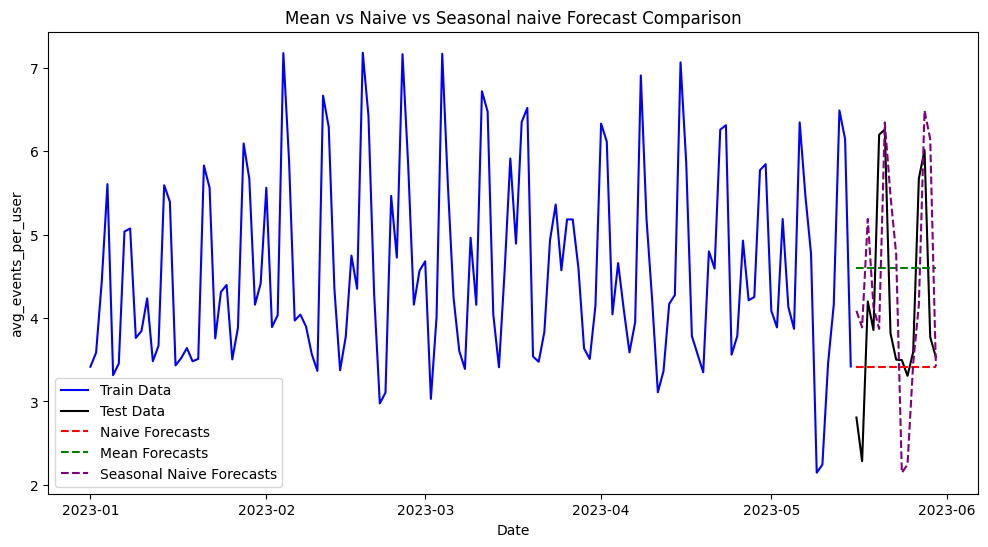

In [128]:
plt.figure(figsize=(12, 6))

plt.plot(train_data.index, train_data['avg_events_per_user'], label='Train Data', color='blue')
plt.plot(test_data.index, test_data['avg_events_per_user'], label='Test Data', color='black')
plt.plot(test_data.index, test_data['naive_forecasts'], label='Naive Forecasts', color='red', linestyle='--')
plt.plot(test_data.index, test_data['mean_forecasts'], label='Mean Forecasts', color='green', linestyle='--')
plt.plot(test_data.index, test_data['seasonal_naive_forecast'], label='Seasonal Naive Forecasts', color='purple', linestyle='--')

plt.title('Mean vs Naive vs Seasonal naive Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('avg_events_per_user')

plt.legend()

plt.show()


Calculating MSE and RMSE for all the methods 

In [129]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [130]:
test_data.head()

,avg_events_per_user,MA7,FO_diff,arima_preds,es_preds,naive_forecasts,seasonal_naive_forecast,mean_forecasts
ev_date,,,,,,,,
2023-05-16,2.807445,4.172307,-0.611985,2.737654,2.775806,3.41943,4.087561,4.604023
2023-05-17,2.283694,4.130747,-0.523751,3.902905,3.557631,3.41943,3.888452,4.604023
2023-05-18,4.199866,4.147056,1.916172,4.474739,3.707900,3.41943,5.189210,4.604023
2023-05-19,3.856751,4.204177,-0.343115,4.590714,4.074977,3.41943,4.132994,4.604023
2023-05-20,6.200353,4.303338,2.343602,5.877980,6.354375,3.41943,3.871468,4.604023


In [131]:
import numpy as np 
actuals = test_data['avg_events_per_user']
forecast_columns = ['arima_preds', 'es_preds', 'naive_forecasts', 'mean_forecasts', 'seasonal_naive_forecast']
errors = {}

for column in forecast_columns:
    mse = mean_squared_error(actuals, test_data[column])
    rmse = np.sqrt(mse)  # Calculate the root mean squared error
    mape = mean_absolute_percentage_error(actuals, test_data[column])
    errors[column] = {'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

for forecast, metrics in errors.items():
    print(f"{forecast} - MSE: {metrics['MSE']:.3f}, RMSE: {metrics['RMSE']:.3f}, MAPE: {metrics['MAPE']:.2f}%")

arima_preds - MSE: 0.521, RMSE: 0.722, MAPE: 0.16%
es_preds - MSE: 0.288, RMSE: 0.537, MAPE: 0.12%
naive_forecasts - MSE: 2.031, RMSE: 1.425, MAPE: 0.21%
mean_forecasts - MSE: 1.691, RMSE: 1.300, MAPE: 0.33%
seasonal_naive_forecast - MSE: 1.746, RMSE: 1.321, MAPE: 0.29%


Conclusion: Exponential smoothing model has the lowest RMSE and MAE, followed by ARIMA. Mean method has the highest MAPE and naive forecasts has the highest RMSE.

In [132]:
test_data.to_csv("test_data.csv")
